TEST LOADER FOR PHOIBOS 150 DATA

Typical structure 
/2020/01 January/Day 10/Raw Data/8874

Withing the folder of the scan number there is an info.txt and a scan
In THE AVG FOLDER there is a set of images, averaged over every acquisition cycle
IN THE RAW FOLDER there are single acquisition cycles (difference: in EPFL we added the "save every n cycle function"
this RAW folder also contains a "LUT.txt" file

In [53]:
# modify this for intersystem compatibility
import os

#get current directory
workingdir=os.getcwd()
#print(workingdir)
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
print("example data path= ",exampledatapath)
#this folders contains the AVG folder with the data, an info.txt vector and a scan vector
#filelist

#navigate to the image folder, for EPFL in the \AVG subfolder of the data (note that single scan cycles for partial load are in another subfolder - to be checked with Laurenz)
avgimagepath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159\AVG'))
print("AVG images path= ",avgimagepath)
rawimagelist=os.listdir(avgimagepath)
#alternatively join the paths
#avgimagepath=os.path.join(exampledatapath,'AVG') 


example data path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159
AVG images path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159\AVG


The shape of the raw data is:  (256, 344)
512 688
1024 1376


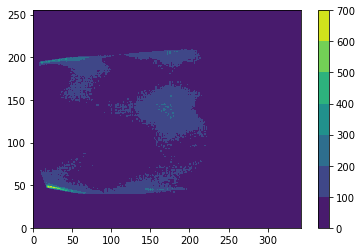

In [54]:
import numpy as np
import matplotlib.pyplot as plt
fname=os.path.join(avgimagepath,rawimagelist[0]) 
raw_data = np.loadtxt(fname, delimiter="\t")

h = plt.contourf(raw_data)
plt.colorbar()
print("The shape of the raw data is: ",raw_data.shape)
#plt.xlim(120,150)
#plt.ylim(150,200)


print(256*2,344*2)
print(256*4,344*4)

one of the first operations should be to filter the image to remove the grid via FFT filtering

In [55]:
#load the module and import functions for reading the parameter table from the calib2d file
from importlib import reload
import specsanalyzer.convert
reload(specsanalyzer.convert)    
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_scanparameters




In [56]:
#GET THE CALIBRATION FILE NAME FROM THE EXAMPLE FOLDER
calib2dfilename=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\phoibosEPFL.txt'))
#GET THE INFO FILE NAME FROM THE EXAMPLE FOLDER, SCAN 9159
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
str_match = list(filter(lambda x: 'info.txt' in x, filelist))
infofilename=os.path.join(exampledatapath,str_match[0]) 

damatrix=get_damatrix_fromcalib2d(infofilename,calib2dfilename)
scanparameters=get_scanparameters(infofilename,calib2dfilename)
# now the calibration matrix contains the ainner in line1 , and the three 
# Da parameters, depending on the mode, some Das might be zero

In [57]:
scanparameters

{'ScanType': 'delay',
 'Averages': '10',
 'Repetitions': '1000',
 'LensMode': 'WideAngleMode',
 'VoltageRange': '400V',
 'Exposure': '200',
 'Gain': '0',
 'Binning': '2',
 'ROIbottom': '33',
 'ROItop': '1',
 'ROIright': '43',
 'ROIleft': '1',
 'DarkImg': '1',
 'KineticEnergy': '35.500000',
 'PassEnergy': '25.000000',
 'CoilCurrent': '3.000000',
 'WorkFunction': '0.000000',
 'DetectorVoltage': '1350.000000',
 'ScreenVoltage': '3000.000000',
 'ConversionVoltage': '-18.000000',
 'FocusDisplacement1': '0.001500',
 'FocusDisplacement2': '0.001500',
 'TimeZero': '281.044000',
 'eShift': [-0.05, 0.0, 0.05],
 'eRange': [-0.066, 0.066],
 'eGrid': [0.01],
 'aGrid': [1.0],
 'De1': [0.003],
 'aRange': [-15.0, 15.0],
 'nx_pixel': 512,
 'ny_pixel': 688,
 'pixelsize': 0.00645,
 'magnification': 4.54,
 'wf': 4.2,
 'aInner': 15.0,
 'damatrix': array([[ 0.699464  ,  0.719724  ,  0.717808  ],
        [ 0.01025504,  0.0765656 ,  0.157344  ],
        [-0.0285464 , -0.072264  , -0.1220944 ],
        [ 0.003

In [58]:
reload(specsanalyzer.convert)    
from specsanalyzer.convert import calculate_polynomial_coef_da

#we now have to convert the polynomial coeffiecients from the Da matrix
dapolymatrix=calculate_polynomial_coef_da(scanparameters)
scanparameters

{'ScanType': 'delay',
 'Averages': '10',
 'Repetitions': '1000',
 'LensMode': 'WideAngleMode',
 'VoltageRange': '400V',
 'Exposure': '200',
 'Gain': '0',
 'Binning': '2',
 'ROIbottom': '33',
 'ROItop': '1',
 'ROIright': '43',
 'ROIleft': '1',
 'DarkImg': '1',
 'KineticEnergy': '35.500000',
 'PassEnergy': '25.000000',
 'CoilCurrent': '3.000000',
 'WorkFunction': '0.000000',
 'DetectorVoltage': '1350.000000',
 'ScreenVoltage': '3000.000000',
 'ConversionVoltage': '-18.000000',
 'FocusDisplacement1': '0.001500',
 'FocusDisplacement2': '0.001500',
 'TimeZero': '281.044000',
 'eShift': [-0.05, 0.0, 0.05],
 'eRange': [-0.066, 0.066],
 'eGrid': [0.01],
 'aGrid': [1.0],
 'De1': [0.003],
 'aRange': [-15.0, 15.0],
 'nx_pixel': 512,
 'ny_pixel': 688,
 'pixelsize': 0.00645,
 'magnification': 4.54,
 'wf': 4.2,
 'aInner': 15.0,
 'damatrix': array([[ 0.699464  ,  0.719724  ,  0.717808  ],
        [ 0.01025504,  0.0765656 ,  0.157344  ],
        [-0.0285464 , -0.072264  , -0.1220944 ],
        [ 0.003

In [59]:
reload(specsanalyzer.convert)
from specsanalyzer.convert import mcp_position_mm

In [60]:
# For the example scan we have the following settings:
ek=float(scanparameters["KineticEnergy"])
ep=float(scanparameters["PassEnergy"])
erange=scanparameters["eRange"]
arange=scanparameters["aRange"]
angles=np.linspace(-20,20,1024)
energies=np.linspace(ek+ep*erange[0],ek+ep*erange[1],2048)
ainner=15
energymesh,anglemesh=np.meshgrid(energies,angles)

testimage=mcp_position_mm(energymesh,anglemesh,scanparameters)

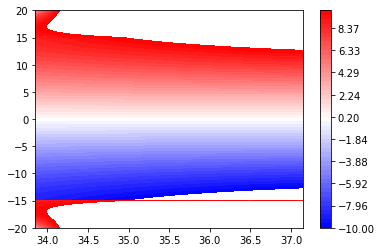

In [61]:
from matplotlib import cm

colorlevels=np.linspace(-10,10,50)

plt.contourf(energies,angles,testimage,cmap=cm.bwr,levels=colorlevels)
#plt.xlim(10,20)
#plt.ylim(-15,15)
#plt.clim(0,5)
plt.colorbar()

#not sure if this is correct.. but better than before

In [62]:
reload(specsanalyzer.convert)
from specsanalyzer.convert import calculate_matrix_correction 


In [63]:
# For the example scan we have the following settings:
(ek_axis, angle_axis, angular_correction_matrix, e_correction,
         jacobian_determinant)=calculate_matrix_correction(scanparameters)

256 344
33.85 37.15
-18.0 18.0


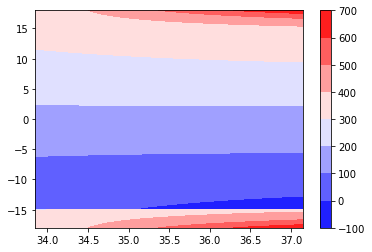

In [64]:
from matplotlib import cm
plt.contourf(ek_axis,angle_axis,angular_correction_matrix,cmap=cm.bwr)
plt.colorbar()

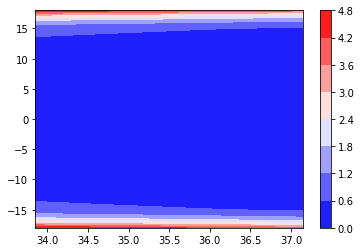

In [65]:
plt.contourf(ek_axis,angle_axis,jacobian_determinant,cmap=cm.bwr)
plt.colorbar()

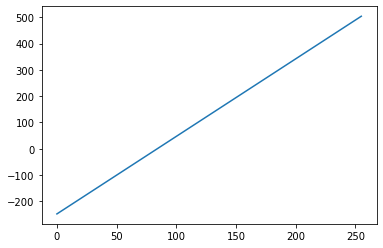

In [68]:
plt.plot(e_correction)

In [66]:

from scipy.interpolate import RegularGridInterpolator

def physical_unit_data(raw_data,
                       ek_axis,
                       angle_axis,
                       angular_correction_matrix,
                       e_correction,
                       jacobian_determinant):
    
    # create 2d matrix with the
    # ek coordinates
    e_correction_expand=np.ones(angular_correction_matrix.shape)*e_correction
    
    # Create a list of e and angle coordinates where to 
    # evaluate the interpolating
    # function
     
    coords=(angular_correction_matrix.flatten(),e_correction_expand.flatten())
    #these coords seems to be pixels..
    
    x_bins=np.arange(0,raw_data.shape[0],1)
    y_bins=np.linspace(0,raw_data.shape[1],1)
    
    #create interpolation function
    my_interpolating_function = RegularGridInterpolator((x_bins,y_bins
                                                         ),
                                                        raw_data,
                                                        method='nearest',
                                                        bounds_error=False,
                                                        fill_value=33)
    corrected_data=np.reshape(my_interpolating_function(coords),
                              angular_correction_matrix.shape)

    return corrected_data
    

In [67]:
print(ek_axis.shape)
print(angle_axis.shape)
print(raw_data.shape)

corrected_data=physical_unit_data(raw_data,
                       ek_axis,
                       angle_axis,
                       angular_correction_matrix,
                       e_correction,
                       jacobian_determinant)

(256,)
(344,)
(256, 344)


ValueError: There are 344 points and 256 values in dimension 0

In [ ]:
  
ek_axis_m,angle_axis_m=np.meshgrid(ek_axis,angle_axis)
ek_axis_m[0,:].shape

(256,)

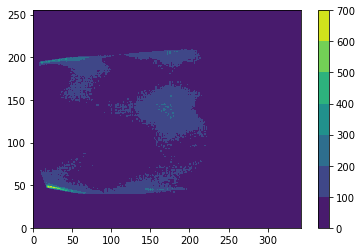

In [ ]:
h = plt.contourf(raw_data)
plt.colorbar()

(256,)
(344,)
(344, 256)


TypeError: Length of x (344) must match number of columns in z (256)

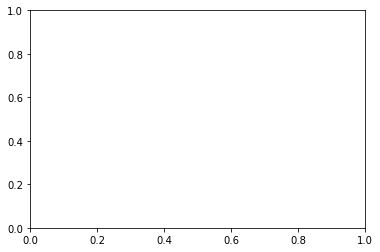

In [ ]:
print(ek_axis.shape)
print(angle_axis.shape)
print(corrected_data.shape)
colorlevels=np.linspace(0,100,100)
h = plt.contourf(angle_axis,ek_axis,corrected_data,levels=colorlevels)
plt.colorbar()


array([[33., 33., 33., ..., 33., 33., 33.],
       [33., 33., 33., ..., 33., 33., 33.],
       [33., 33., 33., ..., 33., 33., 33.],
       ...,
       [33., 33., 33., ..., 33., 33., 33.],
       [33., 33., 33., ..., 33., 33., 33.],
       [33., 33., 33., ..., 33., 33., 33.]])

(3, 4)


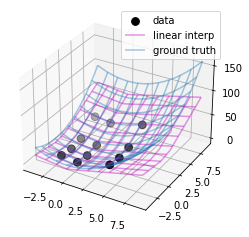

In [ ]:
x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])

def ff(x, y):

    return x**2 + y**2

xg, yg = np.meshgrid(x, y, indexing='ij')

data = ff(xg, yg)


print(data.shape)

interp = RegularGridInterpolator((x, y), data,

                                 bounds_error=False, fill_value=None)
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xg.ravel(), yg.ravel(), data.ravel(),

           s=60, c='k', label='data')

xx = np.linspace(-4, 9, 31)

yy = np.linspace(-4, 9, 31)

X, Y = np.meshgrid(xx, yy, indexing='ij')
# interpolator

ax.plot_wireframe(X, Y, interp((X, Y)), rstride=3, cstride=3,

                  alpha=0.4, color='m', label='linear interp')

# ground truth

ax.plot_wireframe(X, Y, ff(X, Y), rstride=3, cstride=3,

                  alpha=0.4, label='ground truth')

plt.legend()

plt.show()